In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [4]:
cols = ['AIR_TEMP', 'WIND_SPEED', 'ATMO_PRESSURE', 'HUMIDITY', 'RAIN_FALL']
colname = ['AIR_TEMP(°C)', 'WIND_SPEED(m/s)', 'ATMO_PRESSURE(hpa)','HUMIDITY(%)', 'RAIN_FALL(mm)']

In [5]:
def run_Generator(idx):
#   #####################################################
#   ## Loading & Getting predictions from model
#   #####################################################
  df = pd.read_csv(root+'corrected/west_bengal.csv')
  datelist = df['DATE']
  df['DATE']= pd.to_datetime(df['DATE'])
  df = df.drop(columns='DATE')
  training_set = df
  sc = StandardScaler()
  training_set_scaled = sc.fit_transform(training_set)
  sc_predict = StandardScaler()
  sc_predict.fit_transform(training_set.iloc[:, idx:idx+1])
  X_train = []
  y_train = []
  n_future = 1   
  n_past = 60   
  for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, idx])
  X_train, y_train = np.array(X_train), np.array(y_train)
  model = tf.keras.models.load_model(root+'ISRO_MODE/'+cols[idx]+'.h5')
  predictions_train = model.predict(X_train[n_past:])
  y_pred_train = sc_predict.inverse_transform(predictions_train)
  df['DATE'] = datelist 
  y_pred_train[0:].reshape(-1).shape
  hypermodel = tf.keras.models.load_model(root+'ISRO_MODE/SCALERS/'+cols[idx]+'.h5')
  predictions = hypermodel.predict(y_pred_train[0:])
  PREDICTION_TRAIN = pd.DataFrame(predictions, columns=[colname[idx]]).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
  return PREDICTION_TRAIN

In [6]:
genData = run_Generator(4)

In [7]:
predictions = genData.copy()
datelist = genData.index
predictions.describe()

,RAIN_FALL(mm)
count,37866.000000
mean,79.514725
std,93.001778
min,0.865485
25%,9.523438
50%,25.450701
75%,137.802792
max,448.207184


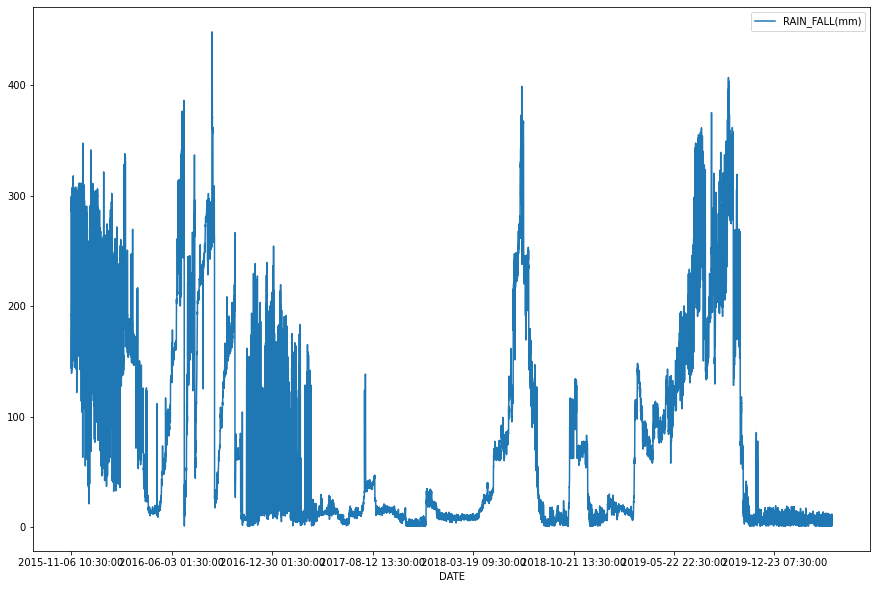

In [8]:
predictions.plot()

In [9]:
data = predictions['RAIN_FALL(mm)']
delta_plus = np.mean(data) + 1.25 * np.std(data)
delta_minus = np.mean(data) - 1.25 * np.std(data)
print(delta_plus)
print(delta_minus)

195.76541137695312
-36.7359619140625


In [10]:
x_data = np.array(predictions.index)

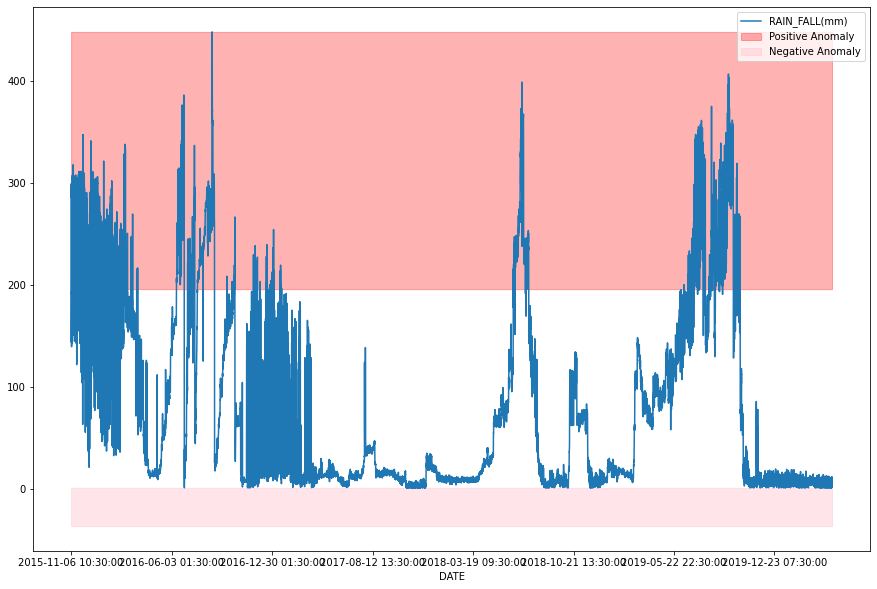

In [11]:
ax = predictions.plot()
ax.fill_between(x_data, max(predictions['RAIN_FALL(mm)']), delta_plus, color = 'red', alpha = 0.3, label='Positive Anomaly')
ax.fill_between(x_data, min(predictions['RAIN_FALL(mm)']), delta_minus, color = 'pink', alpha = 0.4, label='Negative Anomaly')
ax.legend()

In [12]:
predictions['Extreme'] = np.where((predictions['RAIN_FALL(mm)'] > delta_plus) | (predictions['RAIN_FALL(mm)'] < delta_minus), 1, 0)

In [13]:
predictions.describe()

,RAIN_FALL(mm),Extreme
count,37866.000000,37866.000000
mean,79.514725,0.147256
std,93.001778,0.354366
min,0.865485,0.000000
25%,9.523438,0.000000
50%,25.450701,0.000000
75%,137.802792,0.000000
max,448.207184,1.000000


In [14]:
predictions.reset_index(inplace=True)

In [15]:
predictions['DATE'] = pd.to_datetime(predictions['DATE'])

In [16]:
rain_data = predictions['RAIN_FALL(mm)']

In [17]:
predictions.drop(['RAIN_FALL(mm)'], axis = 1, inplace = True)

In [18]:
no_of_hours = predictions['DATE'].dt.date.value_counts().rename('sum').to_frame()

In [19]:
no_of_hours

,sum
2018-02-02,24
2018-07-03,24
2018-07-11,24
2018-07-10,24
2018-07-09,24
...,...
2018-09-19,8
2020-01-02,8
2018-09-20,7
2017-10-21,6


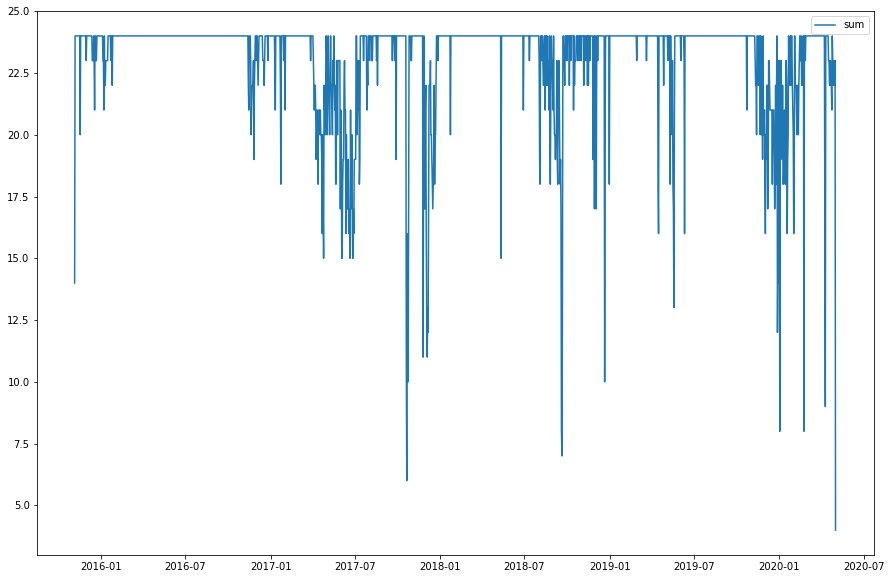

In [20]:
no_of_hours.plot(y='sum')

In [21]:
tempdf = predictions

In [22]:
tempdf['DATE'] = tempdf['DATE'].dt.date

In [23]:
tempdf

,DATE,Extreme
0,2015-11-06,0
1,2015-11-06,0
2,2015-11-06,0
3,2015-11-06,0
4,2015-11-06,0
...,...,...
37861,2020-04-30,0
37862,2020-05-01,0
37863,2020-05-01,0
37864,2020-05-01,0


In [24]:
aggregation_functions = {'Extreme': 'sum'}
df_new = tempdf.groupby(tempdf['DATE']).aggregate(aggregation_functions)

In [25]:
df_new

,Extreme
DATE,
2015-11-06,8
2015-11-07,16
2015-11-08,15
2015-11-09,18
2015-11-10,17
...,...
2020-04-27,0
2020-04-28,0
2020-04-29,0


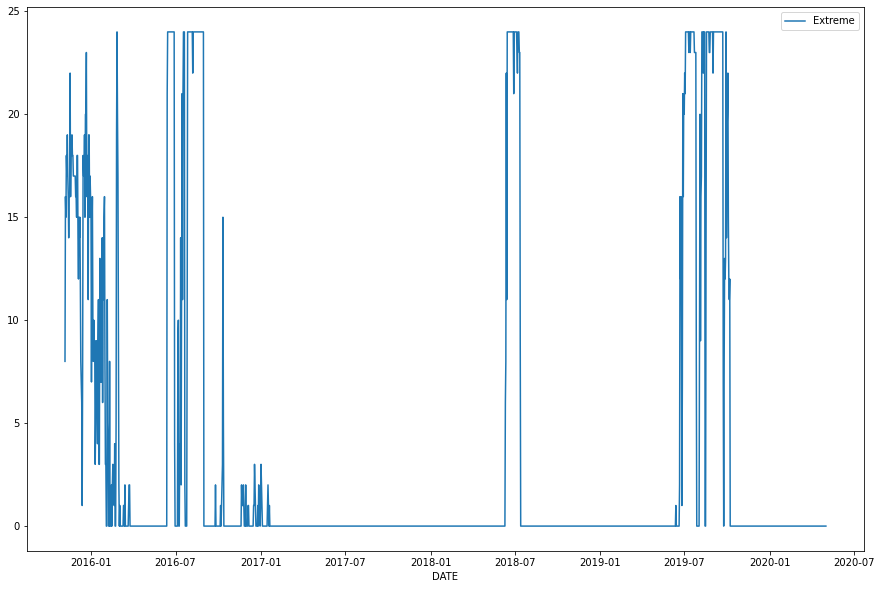

In [26]:
df_new.plot()

In [27]:
df_new.describe()

,Extreme
count,1639.000000
mean,3.402074
std,7.640744
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,24.000000


In [28]:
df_new.loc[df_new['Extreme'] == 24]

,Extreme
DATE,
2016-02-26,24
2016-06-14,24
2016-06-15,24
2016-06-16,24
2016-06-17,24
...,...
2019-09-19,24
2019-09-20,24
2019-09-21,24


In [29]:
data = df_new[['Extreme']]

In [30]:
data['Non-Extreme'] = (no_of_hours['sum'] - data['Extreme']).to_numpy()

In [31]:
data

,Extreme,Non-Extreme
DATE,,
2015-11-06,8,6
2015-11-07,16,8
2015-11-08,15,9
2015-11-09,18,6
2015-11-10,17,7
...,...,...
2020-04-27,0,23
2020-04-28,0,22
2020-04-29,0,22


Text(0.5, 1.0, 'Number of Extremes vs. Non-Extremes')

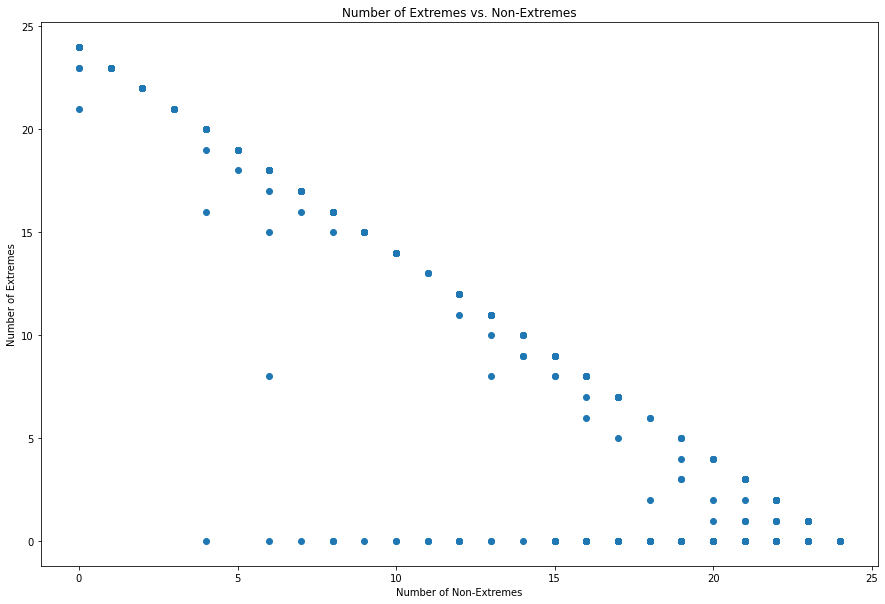

In [32]:
plt.scatter(data['Non-Extreme'], data['Extreme'])
plt.xlabel('Number of Non-Extremes')
plt.ylabel('Number of Extremes')
plt.title('Number of Extremes vs. Non-Extremes')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data['Non-Extreme'], data['Extreme'], test_size=0.2)

In [ ]:
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

# Initialize SVM classifier
clf = svm.SVC(kernel='linear')
# Fit data
clf = clf.fit(X_train, y_train)

# Predict the test set
predictions = clf.predict(X_test)

In [ ]:
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM classifier')
plt.show(matrix)
plt.show()

In [ ]:
X_train[:,0]

In [ ]:
# Get support vectors
support_vectors = clf.support_vectors_

# Visualize support vectors
plt.scatter(X_train, y_train)
# plt.scatter(support_vectors[:,0], support_vectors[:,], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Plot decision boundary
plot_decision_regions(X_test, y_test, clf=clf, legend=2)
plt.show()

In [ ]:
support_vectors